In [1]:
!pip install Keras-Preprocessing
!pip install keras-lr-finder
!pip install kaggle

In [3]:
!mkdir kaggle
import os
import json
api_token = {"username":"dereklai7","key":"052aeb88d00b383c9144da59933f88ce"}
with open('kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

mkdir: cannot create directory ‘kaggle’: File exists


In [4]:
!chmod 600 /content/kaggle/kaggle.json

chmod: cannot access '/content/kaggle/kaggle.json': No such file or directory


In [5]:
!cp /content/kaggle/kaggle.json ~/.kaggle/kaggle.json

cp: cannot stat '/content/kaggle/kaggle.json': No such file or directory


In [6]:
!kaggle datasets download kmader/skin-cancer-mnist-ham10000  -p .

100%|█████████████████████████████████████▉| 5.20G/5.20G [17:15<00:00, 5.89MB/s]
100%|██████████████████████████████████████| 5.20G/5.20G [17:15<00:00, 5.39MB/s]


In [19]:
!unzip -l skin-cancer-mnist-ham10000.zip *.csv

Archive:  skin-cancer-mnist-ham10000.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
   563277  2019-10-06 16:59   HAM10000_metadata.csv
 30807979  2019-10-06 17:03   hmnist_28_28_L.csv
 91820383  2019-10-06 17:03   hmnist_28_28_RGB.csv
  2537778  2019-10-06 17:03   hmnist_8_8_L.csv
  7524968  2019-10-06 17:03   hmnist_8_8_RGB.csv
---------                     -------
133254385                     5 files


In [20]:
!unzip  skin-cancer-mnist-ham10000.zip HAM10000_metadata.csv

Archive:  skin-cancer-mnist-ham10000.zip
  inflating: HAM10000_metadata.csv   


In [9]:
import os
import urllib.request
import zipfile


urls = {
    "train" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip",
    "train_ground_truth" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip",
    "validation" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_Input.zip",
    "validation_ground_truth" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_GroundTruth.zip",
    "test" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_Input.zip",
    "test_ground_truth" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_GroundTruth.zip"
    #"train_seg": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip",
    #"train_seg_gt": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip",
    #"validation_seg": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Validation_Input.zip",
    #"validation_seg_gt": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Validation_GroundTruth.zip",

}

def download_all():
    for item in urls.items():
        name = item[0]
        url = item[1]
        filename = f"{name}.zip"
        if os.path.exists(filename):
            print(f"already exists file {filename}")
        else:
            print(f"downloading {filename} from {url} ...")
            urllib.request.urlretrieve(url, filename)
    print(f"done downloading all")

def unzip_all():
    for item in urls.items():
        name = item[0]
        url = item[1]
        filename = f"{name}.zip"
        print(filename)
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            print(f"unzipping {filename} to folder")
            zip_ref.extractall(f"{name}")

download_all()
unzip_all()

downloading train.zip from https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip ...
downloading train_ground_truth.zip from https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip ...
downloading validation.zip from https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_Input.zip ...
downloading validation_ground_truth.zip from https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_GroundTruth.zip ...
downloading test.zip from https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_Input.zip ...
downloading test_ground_truth.zip from https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_GroundTruth.zip ...
done downloading all
train.zip
unzipping train.zip to folder
train_ground_truth.zip
unzipping train_ground_truth.zip to folder
validation.zip
unzipping validation.zip to folder
validation_ground_truth.zip
unzipping validation_ground_truth.zip to fol

Model code starts here

In [1]:
import keras as k
import tensorflow as tf
import cv2
from keras import layers
from keras_preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
from glob import glob

import pandas as pd
import numpy as np

import sklearn.metrics
import os

2024-02-05 17:37:25.097581: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 17:37:25.097637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 17:37:25.157783: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-05 17:37:25.291524: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 17:37:26.408173: W tensorflow/compiler/tf2

Create Classification Model

In [50]:
def get_classification_112(input_shape):
  inputs = layers.Input(shape=input_shape)
  densenet121 = k.applications.DenseNet121(include_top=False, input_tensor=inputs)#weights='imagenet' #Can use VGG19 instead
  x = densenet121(inputs, training=True) #change back
  #add optional classification layers here (if you add some youll have to change the layer indices in following functions)
  x = layers.Conv2D(64, 3, input_shape=(112,112,3), activation='relu', padding="same")(x)
  x = layers.Conv2D(64, 3, input_shape=(112,112,3), activation='relu', padding="same")(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)

  # output layer, change activation function based on task:
  # multiclass classification = softmax
  # ...
  x = layers.Flatten()(x)
  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dropout(0.1)(x)
  outputs = layers.Dense(7, activation="softmax")(x)
  classification_model_1 = k.Model(inputs=inputs, outputs=outputs, name="classification1")
  return classification_model_1


def get_classification_224(prior): #if input shape issues, use layers.Resizing(shape=(ppfart))
  inputs = layers.Input(shape=(224,224,3))

  #new layers
  x = layers.Conv2D(64, kernel_size=(3, 3), input_shape=(224, 224, 3), activation='relu', padding='same')(inputs)
  x = layers.Conv2D(64, kernel_size=(3, 3), input_shape=(224, 224, 3), activation='relu', padding='same')(x)
  x = layers.Conv2D(3, kernel_size=(3, 3), input_shape=(224, 224, 3), activation='relu', padding='same')(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)

  #print(f"x layers: {x.layers}")
  pretrained = k.models.load_model(prior, custom_objects={"f_score": f_score}) #move metrics up??
  pretrained.layers.pop()
  
  for layer in pretrained.layers[-4:]:
    layer.trainable = False
  x = pretrained(x)
  outputs = layers.Dense(7, activation="softmax")(x)
  temp = k.Model(inputs=inputs, outputs=outputs, name="temp")
  temp.layers.pop()
  inputs2 = layers.Input(shape=(224,224,3))
  y = temp(inputs2)
  outputs2 = layers.Dense(7, activation="softmax")(y)
  """
  x = pretrained.layers[1].layers[2](inputs)
  #remove input layer, replace with new shape
  for layer in pretrained.layers[1].layers[3:]: #every layer except for the first 3
    x = layer(x)
  for layer in x.layers[2]: #the rest of the layers
    x = layer(x)
  """
  #set pretrained layers to untrainable
  #for layer in x.layers[-4:]:
  #  layer.trainable = False

  classification_model_2 = k.Model(inputs=inputs2, outputs=outputs2, name="classification2")
  return classification_model_2





Define Classification Model 1

In [3]:
input_shape=(112,112,3)
classification_1 = get_classification_112(input_shape)

2024-02-05 17:37:40.587382: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-05 17:37:40.773416: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-05 17:37:40.773465: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-05 17:37:40.775519: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-05 17:37:40.775569: I external/local_xla/xla/stream_executor

In [4]:
classification_1.summary()

Model: "classification1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 3, 3, 1024)        7037504   
                                                                 
 conv2d (Conv2D)             (None, 3, 3, 64)          589888    
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 1, 64)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                   

Define metrics, ImageDataGenerator, and get_weights.

In [5]:
cls_train_gt = 'train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'#("classi/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv")
cls_val = r'validation/ISIC2018_Task3_Validation_Input/'
cls_val_gt = "validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"

#weighted binary loss
def get_weights(labels):
    cols = len(labels.columns)-2 #assumes 1 column for image ids
    weights = {}
    for i in range(cols+1):
        weights[i] = 1-np.mean(labels[labels.columns[i+1]].tolist())
    return weights

weights = get_weights(pd.read_csv(cls_train_gt))
print(get_weights(pd.read_csv(cls_train_gt)))

from keras import backend as K
def f_score(y_true, y_pred, threshold=0.1, beta=2):
    tp = tp_score(y_true, y_pred, threshold)
    fp = fp_score(y_true, y_pred, threshold)
    fn = fn_score(y_true, y_pred, threshold)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return (1+beta**2) * ((precision * recall) / ((beta**2)*precision + recall))

def tp_score(y_true, y_pred, threshold=0.1):
    tp_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(y_true)), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.greater(y_pred, K.constant(threshold)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=1
    )
    tp = K.sum(K.cast(K.all(tp_3d, axis=1), 'int32'))
    return tp

def fp_score(y_true, y_pred, threshold=0.1):
    fp_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(K.abs(y_true - K.ones_like(y_true)))), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.greater(y_pred, K.constant(threshold)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=-1
    )

    fp = K.sum(K.cast(K.all(fp_3d, axis=1), 'int32'))
    return fp

def fn_score(y_true, y_pred, threshold=0.1):
    fn_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(y_true)), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.abs(K.cast(K.greater(y_pred, K.constant(threshold)), 'float') - K.ones_like(y_pred)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=1
    )

    fn = K.sum(K.cast(K.all(fn_3d, axis=1), 'int32'))
    return fn

def precision_score(y_true, y_pred, threshold=0.1):
    tp = tp_score(y_true, y_pred, threshold)
    fp = fp_score(y_true, y_pred, threshold)
    return tp / (tp + fp)

def recall_score(y_true, y_pred, threshold=0.1):
    tp = tp_score(y_true, y_pred, threshold)
    fn = fn_score(y_true, y_pred, threshold)
    return tp / (tp + fn)

cls_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True) #Can also add rotation, width/height shifting...


{0: 0.888866699950075, 1: 0.3305042436345482, 2: 0.9486769845232151, 3: 0.9673489765351972, 4: 0.8902646030953569, 5: 0.9885172241637543, 6: 0.9858212680978532}


Evaluation "Metrics" Functions

In [6]:
def print_metrics(history, epochs):
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_acc  = history.history['accuracy']
  val_acc    = history.history['val_accuracy']

  plt.figure()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.plot(range(epochs), train_loss)
  plt.plot(range(epochs), val_loss)

  plt.figure()
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.plot(range(epochs), train_acc)
  plt.plot(range(epochs), val_acc)

def accuracy_from_val(model, val_x_path, val_y_path):
  preds = model.predict(val_x_path)
  acc = sklearn.metrics.accuracy_score(preds, val_y_path)
  print('The accuracy is {0} % .'.format(acc*100))


Load & preprocess data.

In [7]:
#Prepare val_y csv & train_y_h10000
val_y = "validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"
train_y_h10000 = 'HAM10000_metadata.csv'

df_val_meta = pd.read_csv(val_y)
df_train = pd.read_csv(train_y_h10000)

#add suffixes
df_val_meta['img_id'] = df_val_meta['image'] + '.jpg'
df_train['img_id'] = df_train['image_id'] + '.jpg'

#Replace all binarized labels with their corresponding string label
df_val_meta['bits_num'] = df_val_meta['MEL'] * 1 + df_val_meta['NV'] * 2 + df_val_meta['BCC'] *4 + df_val_meta['AKIEC']*8 +  \
    df_val_meta['BKL']*16 + df_val_meta['DF']*32 + + df_val_meta['VASC']*64

labels = { 1.0 :"mel", 2.0:"nv", 4.0:"bcc", 8.0:"akiec", 16.0:"bkl", 32.0:"df", 64.0:"vasc" }

def to_dx(bits_num):
    return labels.get(bits_num)

df_val_meta["dx"] = df_val_meta["bits_num"].apply(to_dx)

In [8]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
df_val_meta["dx_encoded"] = label_encoder.fit_transform(df_val_meta["dx"])
df_train["dx_encoded"] = label_encoder.fit_transform(df_train["dx"])

"""
df_val_meta["dx2"] = k.utils.to_categorical(df_val_meta["dx"], 7)
df_train["dx2"] = k.utils.to_categorical(df_train["dx"], 7)
"""

'\ndf_val_meta["dx2"] = k.utils.to_categorical(df_val_meta["dx"], 7)\ndf_train["dx2"] = k.utils.to_categorical(df_train["dx"], 7)\n'

In [9]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit([[0,0,0,0,0,0,1], [1,0,0,0,0,0,0]])
print(lb.transform([0,1,2,3,4]))

print(df_val_meta["dx_encoded"].shape)

[[1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]]
(193,)


In [10]:
df_val_meta.sample(5)

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,img_id,bits_num,dx,dx_encoded
47,ISIC_0034371,0.0,0.0,0.0,0.0,1.0,0.0,0.0,ISIC_0034371.jpg,16.0,bkl,2
144,ISIC_0034474,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ISIC_0034474.jpg,2.0,nv,5
80,ISIC_0034407,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ISIC_0034407.jpg,2.0,nv,5
90,ISIC_0034417,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ISIC_0034417.jpg,2.0,nv,5
187,ISIC_0034518,0.0,1.0,0.0,0.0,0.0,0.0,0.0,ISIC_0034518.jpg,2.0,nv,5


In [11]:
df_train.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,img_id,dx_encoded
2332,HAM_0004765,ISIC_0031217,vasc,histo,15.0,male,face,ISIC_0031217.jpg,6
4829,HAM_0005516,ISIC_0028748,nv,follow_up,50.0,male,abdomen,ISIC_0028748.jpg,5
2831,HAM_0002689,ISIC_0026687,bcc,histo,60.0,male,lower extremity,ISIC_0026687.jpg,1
5431,HAM_0004688,ISIC_0032000,nv,follow_up,60.0,male,upper extremity,ISIC_0032000.jpg,5
1582,HAM_0001928,ISIC_0032537,mel,histo,55.0,male,chest,ISIC_0032537.jpg,4


In [13]:
print(df_train.isnull().sum())
print(df_val_meta.isnull().sum())

df_train["age"].fillna(50, inplace=True)

print(df_train.isnull().sum())
print(df_val_meta.isnull().sum())

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
img_id          0
dx_encoded      0
dtype: int64
image         0
MEL           0
NV            0
BCC           0
AKIEC         0
BKL           0
DF            0
VASC          0
img_id        0
bits_num      0
dx            0
dx_encoded    0
dtype: int64


In [14]:
val_x = 'validation/ISIC2018_Task3_Validation_Input/'
val_y = "validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"

train_x = 'train/ISIC2018_Task3_Training_Input/'
train_y = 'train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'


batch_size = 4

seed=123

train_data = cls_datagen.flow_from_dataframe(df_train, directory=train_x, x_col="img_id", y_col="dx", target_size=(112,112), color_mode='rgb', class_mode='categorical', batch_size=batch_size, shuffle=True)
val_data = cls_datagen.flow_from_dataframe(df_val_meta, directory=val_x, x_col="img_id", y_col="dx", target_size=(112,112), color_mode='rgb', class_mode='categorical', batch_size=batch_size, shuffle=True)


Found 10015 validated image filenames belonging to 7 classes.
Found 193 validated image filenames belonging to 7 classes.


In [15]:
print(len(val_data))
print(len(train_data))
print(train_data.samples)

49
2504
10015


Compile and train the model

In [57]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.002) #Modify learning rate if needed
classification_1.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", f_score, 'AUC'])
callbacks = []#k.callbacks.EarlyStopping(patience=5)
epochs1 = 25
batch_size = 4
steps_per_epoch = 4

history1 = classification_1.fit(train_data, epochs=epochs1, steps_per_epoch=steps_per_epoch, class_weight=weights, batch_size=len(train_data), validation_data=val_data, verbose=1, callbacks=callbacks)

classification_1.save("classification_1.keras")

print_metrics(history1, epochs1)


# accuracy_from_val(classification_1, val_x, val_y)



Epoch 1/25


KeyboardInterrupt: 

In [51]:
#Classification Stage 2
classification_2 = get_classification_224("classification_1.keras")
classification_2.summary()

Model: "classification2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 temp (Functional)           (None, 7)                 7723266   
                                                                 
 dense_6 (Dense)             (None, 7)                 56        
                                                                 
Total params: 7723322 (29.46 MB)
Trainable params: 7621235 (29.07 MB)
Non-trainable params: 102087 (398.78 KB)
_________________________________________________________________


In [43]:
batch_size2 = 4
train_data2 = cls_datagen.flow_from_dataframe(df_train, directory=train_x, x_col="img_id", y_col="dx", target_size=(224,224), color_mode='rgb', class_mode='categorical', batch_size=batch_size2, shuffle=True)
val_data2 = cls_datagen.flow_from_dataframe(df_val_meta, directory=val_x, x_col="img_id", y_col="dx", target_size=(224,224), color_mode='rgb', class_mode='categorical', batch_size=batch_size2, shuffle=True)

Found 10015 validated image filenames belonging to 7 classes.
Found 193 validated image filenames belonging to 7 classes.


In [54]:
l_rate_2 = 0.001
epochs2 = 40
steps_per_epoch2 = 4

optimizer2 = tf.keras.optimizers.SGD(learning_rate=l_rate_2)
classification_2.compile(optimizer=optimizer2, loss="categorical_crossentropy", metrics=["accuracy", f_score, 'AUC'])
callbacks = []#k.callbacks.EarlyStopping(patience=5)

history2 = classification_2.fit(train_data2, epochs=epochs2, steps_per_epoch=steps_per_epoch2, class_weight=weights, batch_size=len(train_data), validation_data=val_data2, verbose=1, callbacks=callbacks)
classification_2.save("classification_2.keras")

Epoch 1/40


2024-02-05 20:43:53.238468: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-05 20:43:53.362891: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-05 20:43:53.546510: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-05 20:43:59.372850: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f3bb40cc940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-05 20:43:59.372890: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
I0000 00:00:1707194639.424562     978 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 [==============================] - 47s 2s/step - loss: 1.8096 - accuracy: 0.0625 - f_score: 0.4545 - auc: 0.6631 - val_loss: 1.8658 - val_accuracy: 0.0415 - val_f_score: 0.4545 - val_auc: 0.7159
Epoch 2/40
4/4 [==============================] - 2s 644ms/step - loss: 1.7433 - accuracy: 0.0000e+00 - f_score: 0.4545 - auc: 0.6992 - val_loss: 1.8637 - val_accuracy: 0.0415 - val_f_score: 0.4545 - val_auc: 0.7147
Epoch 3/40
4/4 [==============================] - 2s 684ms/step - loss: 1.5316 - accuracy: 0.0000e+00 - f_score: 0.4545 - auc: 0.6081 - val_loss: 1.8626 - val_accuracy: 0.0415 - val_f_score: 0.4545 - val_auc: 0.7148
Epoch 4/40
4/4 [==============================] - 2s 681ms/step - loss: 1.7951 - accuracy: 0.1250 - f_score: 0.4545 - auc: 0.6738 - val_loss: 1.8618 - val_accuracy: 0.0415 - val_f_score: 0.4545 - val_auc: 0.7140
Epoch 5/40
4/4 [==============================] - 2s 665ms/step - loss: 1.7941 - accuracy: 0.0000e+00 - f_score: 0.4545 - auc: 0.7760 - val_loss: 1.8600 - va

Evaluation and Testing


1/1 [==============================] - 0s 29ms/step
True Label:            image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
11  ISIC_0034535  0.0  0.0  0.0    0.0  1.0  0.0   0.0
Predicted Scores: [[0.02994625 0.0137396  0.10090231 0.01118257 0.05243101 0.7813926
  0.01040569]]


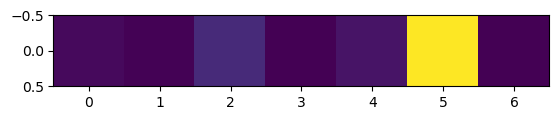

This image most likely belongs to DF with a 78.14 percent confidence.


In [53]:
class_names=["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]

pred_folder = "test/ISIC2018_Task3_Test_Input"
pred_image = "ISIC_00345" + str(np.random.randint(10, 99))
labels_path = "test_ground_truth/ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv"

pred_label_df = pd.read_csv(labels_path)
pred_label_true = pred_label_df.loc[pred_label_df['image']==pred_image]

test_image = np.array(cv2.imread(os.path.join(pred_folder, pred_image) + ".jpg"))
pred_image = cv2.resize(test_image, (112,112))

img_array = tf.keras.utils.img_to_array(pred_image)
img_array = tf.expand_dims(img_array, 0) # Create a batch

score = classification_1.predict(img_array)
label_name = class_names[np.argmax(score)]
confidence_percent = 100 * np.max(score)

print(f"True Label: {pred_label_true}")

print(f"Predicted Scores: {score}")
plt.imshow(score, interpolation="nearest")
plt.show()

print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(label_name, confidence_percent))

In [ ]:
#Confusion Matrix
x_test_path = "test/ISIC2018_Task3_Test_Input"
y_test_path = "test_ground_truth/ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv"

x_test, y_test = load_images_and_labels(x_test_path, y_test_path, len(pd.read_csv(y_test_path)), (112,112), True)

y_prediction = classification.predict(x_test)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test=np.argmax(y_test, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(result, cmap=plt.cm.Blues, alpha=0.3)
for i in range(result.shape[0]):
    for j in range(result.shape[1]):
        ax.text(x=j, y=i,s=np.round(result[i, j], 3), va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Converting to .tflite

In [ ]:
def convert_to_tflite(model, name):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(str(name), 'wb') as f:
      f.write(tflite_model)